# Test OCR Engine

Notebook để test module `OCREngine` từ `src/extraction/ocr_engine.py`.

## Features:
- Test EasyOCR và Tesseract OCR
- Read text từ image regions
- Classify chart labels (title, xlabel, ylabel, values)
- Visualize results


In [2]:
# Setup
import sys
from pathlib import Path

# Add project root to path
# Notebook is in bleh/notebooks/, so project_root should be bleh/ (one level up)
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Import modules
from src.extraction.ocr_engine import OCREngine
from src.preprocessing.image_utils import ImagePreprocessor
from src.preprocessing.chart_detector import ChartComponentDetector

print("Setup complete!")


Setup complete!


In [3]:
# Initialize OCR engine
try:
    ocr_engine = OCREngine(languages=['en', 'vi'], gpu=False)
    print("OCR Engine initialized successfully!")
    print(f"Available engines:")
    print(f"  - EasyOCR: {ocr_engine.easyocr_reader is not None}")
    
    # Check Tesseract availability
    try:
        import pytesseract
        print(f"  - Tesseract: {pytesseract is not None}")
    except ImportError:
        print(f"  - Tesseract: False (not installed)")
except Exception as e:
    print(f"Error initializing OCR engine: {e}")


Using CPU. Note: This module is much faster with a GPU.


OCR Engine initialized successfully!
Available engines:
  - EasyOCR: True
  - Tesseract: True


## Test 1: Read Text from Full Image using EasyOCR


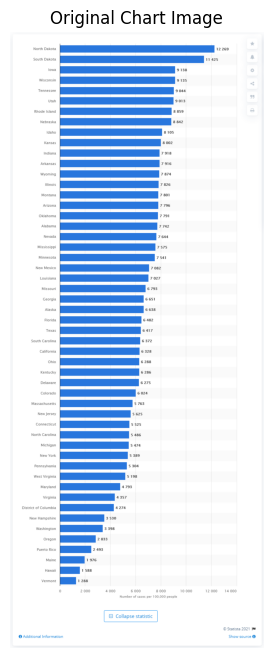

c:\Users\minht\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Found 115 text detections:
1. Text: 'North Dakota' | Confidence: 0.997
2. Text: '12 269' | Confidence: 0.995
3. Text: 'South Dakota' | Confidence: 0.958
4. Text: '11 425' | Confidence: 0.935
5. Text: 'lowa' | Confidence: 0.937
6. Text: '138' | Confidence: 0.998
7. Text: 'Wisconsin' | Confidence: 1.000
8. Text: '135' | Confidence: 0.997
9. Text: 'Tennessee' | Confidence: 1.000
10. Text: '044' | Confidence: 1.000
11. Text: 'Utah' | Confidence: 0.999
12. Text: '013' | Confidence: 1.000
13. Text: 'Rhode Island' | Confidence: 0.752
14. Text: '859' | Confidence: 1.000
15. Text: 'Nebraska' | Confidence: 1.000
16. Text: '842' | Confidence: 0.996
17. Text: 'Idaho' | Confidence: 0.999
18. Text: '105' | Confidence: 1.000
19. Text: 'Kansas' | Confidence: 0.979
20. Text: '002' | Confidence: 0.983
21. Text: 'Indiana' | Confidence: 0.999
22. Text: '7 918' | Confidence: 0.868
23. Text: 'Arkansas' | Confidence: 0.809
24. Text: '916' | Confidence: 1.000
25. Text: 'Wyoming' | Confidence: 0.906
26. Text:

In [4]:
# Load a test image
image_path = project_root / "data" / "raw" / "bar_charts" / "chart_0000.png"

if image_path.exists():
    # Load and preprocess image
    preprocessor = ImagePreprocessor()
    image = preprocessor.load_image(str(image_path))
    
    # Display image
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title("Original Chart Image")
    plt.axis('off')
    plt.show()
    
    # Try reading text with EasyOCR
    try:
        detections = ocr_engine.read_text_easyocr(image, confidence_threshold=0.3)
        print(f"\nFound {len(detections)} text detections:")
        for i, det in enumerate(detections, 1):
            print(f"{i}. Text: '{det['text']}' | Confidence: {det['confidence']:.3f}")
    except Exception as e:
        print(f"Error reading text with EasyOCR: {e}")
else:
    print(f"Image not found: {image_path}")
    print("Please run generate_dataset.py first to create test images.")


## Test 2: Read Text from Specific Region


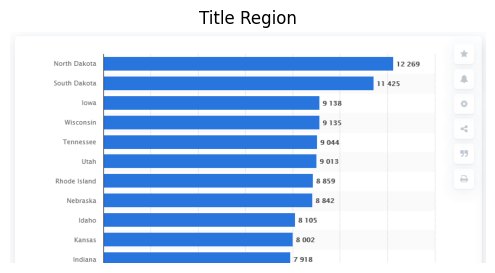


Text found in title region:
  - 'North Dakota' (confidence: 0.997)
  - '12 269' (confidence: 0.995)
  - 'South Dakota' (confidence: 0.958)
  - '11 425' (confidence: 0.935)
  - 'lowa' (confidence: 0.937)
  - '138' (confidence: 0.998)
  - 'Wisconsin' (confidence: 1.000)
  - '135' (confidence: 0.997)
  - 'Tennessee' (confidence: 1.000)
  - '044' (confidence: 1.000)
  - 'Utah' (confidence: 0.999)
  - '013' (confidence: 1.000)
  - 'Rhode Island' (confidence: 0.752)
  - '859' (confidence: 1.000)
  - 'Nebraska' (confidence: 1.000)
  - '842' (confidence: 0.996)
  - 'Idaho' (confidence: 0.999)
  - '105' (confidence: 1.000)
  - 'Kansas' (confidence: 0.979)
  - '8 002' (confidence: 0.998)
  - 'Indian' (confidence: 1.000)
  - '7 918' (confidence: 0.967)


In [5]:
# Extract a specific region (e.g., title area)
if image_path.exists():
    # Load image
    preprocessor = ImagePreprocessor()
    image = preprocessor.load_image(str(image_path))
    
    h, w = image.shape[:2]
    
    # Extract title region (top 20% of image)
    title_region = image[0:int(h*0.2), :]
    
    # Display region
    plt.figure(figsize=(12, 3))
    plt.imshow(title_region)
    plt.title("Title Region")
    plt.axis('off')
    plt.show()
    
    # Read text from region
    try:
        detections = ocr_engine.read_text_easyocr(title_region, confidence_threshold=0.3)
        print(f"\nText found in title region:")
        for det in detections:
            print(f"  - '{det['text']}' (confidence: {det['confidence']:.3f})")
    except Exception as e:
        print(f"Error: {e}")


## Test 3: Compare EasyOCR vs Tesseract


In [6]:
# Compare both OCR methods
if image_path.exists():
    preprocessor = ImagePreprocessor()
    image = preprocessor.load_image(str(image_path))
    
    h, w = image.shape[:2]
    title_region = image[0:int(h*0.2), :]
    
    print("=== EasyOCR Results ===")
    try:
        easyocr_results = ocr_engine.read_text_easyocr(title_region, confidence_threshold=0.3)
        for det in easyocr_results:
            print(f"  - '{det['text']}' (conf: {det['confidence']:.3f})")
    except Exception as e:
        print(f"  Error: {e}")
    
    print("\n=== Tesseract Results ===")
    try:
        tesseract_results = ocr_engine.read_text_tesseract(title_region)
        for det in tesseract_results:
            print(f"  - '{det['text']}' (conf: {det['confidence']:.3f})")
    except Exception as e:
        print(f"  Error: {e}")


=== EasyOCR Results ===
  - 'North Dakota' (conf: 0.997)
  - '12 269' (conf: 0.995)
  - 'South Dakota' (conf: 0.958)
  - '11 425' (conf: 0.935)
  - 'lowa' (conf: 0.937)
  - '138' (conf: 0.998)
  - 'Wisconsin' (conf: 1.000)
  - '135' (conf: 0.997)
  - 'Tennessee' (conf: 1.000)
  - '044' (conf: 1.000)
  - 'Utah' (conf: 0.999)
  - '013' (conf: 1.000)
  - 'Rhode Island' (conf: 0.752)
  - '859' (conf: 1.000)
  - 'Nebraska' (conf: 1.000)
  - '842' (conf: 0.996)
  - 'Idaho' (conf: 0.999)
  - '105' (conf: 1.000)
  - 'Kansas' (conf: 0.979)
  - '8 002' (conf: 0.998)
  - 'Indian' (conf: 1.000)
  - '7 918' (conf: 0.967)

=== Tesseract Results ===
  - 'North' (conf: 0.960)
  - 'Dakota' (conf: 0.930)
  - 'South' (conf: 0.960)
  - 'Dakota' (conf: 0.820)
  - 'utah' (conf: 0.850)
  - 'Island' (conf: 0.660)
  - 'Nebraska' (conf: 0.960)
  - 'Idaho' (conf: 0.810)
  - 'Kansas' (conf: 0.950)
  - 'Indiana' (conf: 0.890)
  - '12269' (conf: 0.870)
  - '11425' (conf: 0.660)


## Test 4: Detect Text Regions and Classify Labels


Detected 7 text regions


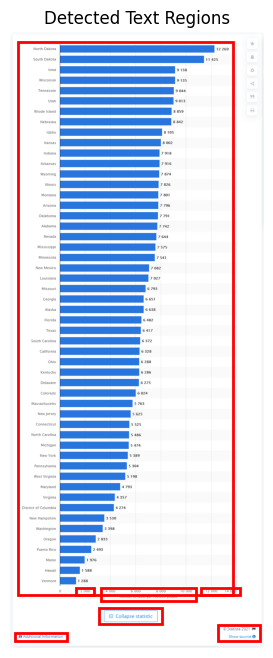


=== Classified Labels ===
Title: 
X-axis label: 0oo Number of cases per 100,000 people
Y-axis label: 

Values (2 found):
  - 'North Dakota 12 269 South Dakota 425 Owa 138 Wisconsin 9 135 Tennessee 044 Utah 013 Rhode Island 859 Nebraska 8 842 Idaho 105 Kansas 002 Indiana 918 Arkansas 916 Wyoming 7 874 Illinois 826 Montana 801 Arizona 796 Oklahoma 791 Alabama 742 Nevada 7 644 Mississippi 575 Minnesota 541 New Mexico 082 Louisiana 027 Missouri 793 Ceorgia 6 651 Alaska 638 Florida 482 Texas 417 South Carolina 372 California 328 Ohio Kentucky 286 Delaware 275 Colorado 024 Massachusetts 763 New Jersey 625 Connecticut 525 North Carolina 486 Michigan 474 New York 389 Pennsylvania 304 West Virginia 198 Maryland 793 Virginia 357 District of Columbia 274 New Hampshire 530 Washington 398 Oregon 833 Puerto Rico 493 Maine 976 Hawaii 588 Vermont 288' at (364, 903)
  - 'Additional Informaticn' at (97, 1910)


In [7]:
# Full pipeline: Detect text regions and classify labels
if image_path.exists():
    # Load and preprocess
    preprocessor = ImagePreprocessor()
    image = preprocessor.load_image(str(image_path))
    
    # Detect text regions
    detector = ChartComponentDetector(preprocessor)
    text_regions = detector.detect_text_regions(image)
    
    print(f"Detected {len(text_regions)} text regions")
    
    # Display image with text regions
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image)
    
    for x, y, w, h in text_regions:
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    
    ax.set_title("Detected Text Regions")
    ax.axis('off')
    plt.show()
    
    # Read and classify labels
    try:
        labels = ocr_engine.read_chart_labels(image, text_regions, ocr_method='easyocr')
        
        print("\n=== Classified Labels ===")
        print(f"Title: {labels['title']}")
        print(f"X-axis label: {labels['xlabel']}")
        print(f"Y-axis label: {labels['ylabel']}")
        print(f"\nValues ({len(labels['values'])} found):")
        for val in labels['values'][:10]:  # Show first 10
            print(f"  - '{val['text']}' at {val['position']}")
    except Exception as e:
        print(f"Error: {e}")


## Test 5: Visualize OCR Results on Chart


C:\Users\minht\AppData\Local\Temp\ipykernel_18860\2138550366.py:33: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


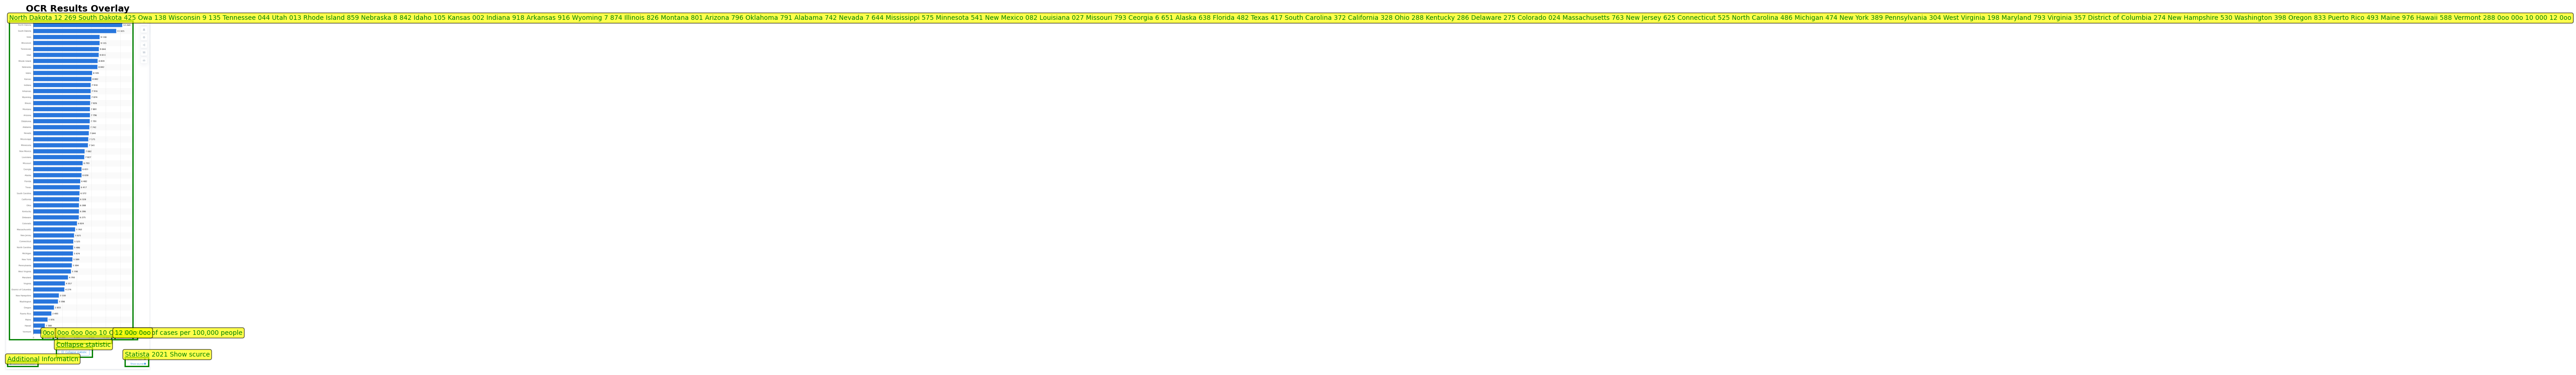

In [8]:
# Visualize OCR results on chart image
if image_path.exists():
    preprocessor = ImagePreprocessor()
    image = preprocessor.load_image(str(image_path))
    
    detector = ChartComponentDetector(preprocessor)
    text_regions = detector.detect_text_regions(image)
    
    # Read text from all regions
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.imshow(image)
    
    # Process each text region
    for x, y, w, h in text_regions:
        roi = image[y:y+h, x:x+w]
        try:
            detections = ocr_engine.read_text_easyocr(roi, confidence_threshold=0.3)
            if detections:
                # Draw bounding box
                rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='green', facecolor='none')
                ax.add_patch(rect)
                
                # Add text
                text = " ".join([d['text'] for d in detections])
                ax.text(x, y-5, text, fontsize=10, color='green', 
                       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
        except Exception as e:
            # Skip regions with errors
            pass
    
    ax.set_title("OCR Results Overlay", fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()


## Test 6: Process Multiple Charts


In [9]:
# Process multiple charts and compare results
chart_dir = project_root / "data" / "raw" / "bar_charts"
chart_files = sorted(chart_dir.glob("chart_*.png"))[:5]  # Test first 5 charts

if chart_files:
    preprocessor = ImagePreprocessor()
    detector = ChartComponentDetector(preprocessor)
    
    results = []
    
    for chart_path in chart_files:
        try:
            image = preprocessor.load_image(str(chart_path))
            text_regions = detector.detect_text_regions(image)
            labels = ocr_engine.read_chart_labels(image, text_regions, ocr_method='easyocr')
            
            results.append({
                'file': chart_path.name,
                'title': labels['title'],
                'xlabel': labels['xlabel'],
                'ylabel': labels['ylabel'],
                'num_values': len(labels['values'])
            })
        except Exception as e:
            print(f"Error processing {chart_path.name}: {e}")
    
    # Display results
    print("=== OCR Results Summary ===\n")
    for res in results:
        print(f"Chart: {res['file']}")
        print(f"  Title: {res['title'] or 'N/A'}")
        print(f"  X-label: {res['xlabel'] or 'N/A'}")
        print(f"  Y-label: {res['ylabel'] or 'N/A'}")
        print(f"  Values found: {res['num_values']}")
        print()
else:
    print("No chart files found. Please run generate_dataset.py first.")


=== OCR Results Summary ===

Chart: chart_0000.png
  Title: N/A
  X-label: 0oo Number of cases per 100,000 people
  Y-label: N/A
  Values found: 2

Chart: chart_0001.png
  Title: N/A
  X-label: N/A
  Y-label: N/A
  Values found: 1

Chart: chart_0002.png
  Title: N/A
  X-label: N/A
  Y-label: N/A
  Values found: 1

Chart: chart_0003.png
  Title: N/A
  X-label: N/A
  Y-label: N/A
  Values found: 1

Chart: chart_0004.png
  Title: N/A
  X-label: N/A
  Y-label: N/A
  Values found: 1

